In [1]:
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt

import glob
import os
import datetime

In [2]:
path = '/Users/margaretmccall/Documents/2020 Spring/CE 295/0 - Final Project/data_dump_will/'

# AS_price

EDA observations:
* ISO: ERCOT
* Markets = DAH, RTH
* Date range = 1/1/14 to 1/1/19
* Price type = Down Regulation, Non-Spinning Reserve, Responsive Reserve, Up Regulation
* There's only one price node ID
* KEEP: Market, Price Type (sep tables?), Date, Time, Price, Volume

In [3]:
df_as = pd.read_csv(path+'AS_price 2.csv') #no longer need first AS file

In [4]:
df_as.head(1)

,Price Node Name,ISO Name,Market,Price Type,Price Type Full Description,Local Datetime (Hour Ending),Time Zone,Local Datetime (Hour Beginning),GMT Datetime (Hour Beginning),Price $/MWh,Volume MWh,Record Count,Price Node ID,ISO Name ID
0,ERCOT,ERCOT ISO,DAH,Down Regulation,ERCOT-DAH Down Regulation,1/1/2014 01:00,CST,1/1/2014 00:00,1/1/2014 06:00,5.65,319.0,1,849244,72672


In [5]:
df_as['dt'] = pd.to_datetime(df_as['Local Datetime (Hour Beginning)'])

In [6]:
df_as['date'] = df_as['dt'].dt.date
df_as['time_beginning'] = df_as['dt'].dt.time

In [7]:
type(df_as['dt'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
type(df_as['date'][0])

datetime.date

In [9]:
df_as = df_as[['Market','Price Type','date','time_beginning','Price $/MWh','Volume MWh']]
df_as.columns = ['market','product','date','hr_beg','price','volume']

In [10]:
#Separating markets and products
as_dict = {}
for mark in df_as['market'].unique():
    for prod in df_as['product'].unique():
        as_dict[mark+prod] = df_as.loc[(df_as['market']==mark) 
                                       & (df_as['product']==prod),'date':].reset_index(drop=True)
        as_dict[mark+prod].sort_values(by=['date','hr_beg']).reset_index(drop=True)

In [11]:
df_as.head()

,market,product,date,hr_beg,price,volume
0,DAH,Down Regulation,2014-01-01,00:00:00,5.65,319.0
1,DAH,Down Regulation,2014-01-01,01:00:00,5.55,284.0
2,DAH,Down Regulation,2014-01-01,02:00:00,5.55,311.0
3,DAH,Down Regulation,2014-01-01,03:00:00,8.11,360.0
4,DAH,Down Regulation,2014-01-01,04:00:00,8.11,380.0


In [15]:
df_as = df_as.drop_duplicates(keep='first')

In [17]:
as_output = df_as.loc[:,'date':'hr_beg']

In [33]:
products = ['Down Regulation', 'Non-Spinning Reserve', 'Responsive Reserve',
       'Up Regulation']
new_products = ['REGDN','NSPIN','RRS','REGUP']

as_output = df_as.loc[:,'date':'hr_beg']

for market in ['DAH']:
    for i, prod in enumerate(products[0:2]):
        subset = df_as.loc[(df_as['market']==market) & (df_as['product']==prod),['date','hr_beg','price','volume']].rename(columns={'price':'price'+"_"+market+"_"+new_products[i],
                                                                                                                    'volume':'vol'+"_"+market+"_"+new_products[i]})
        as_output = as_output.merge(subset, how="outer", on=['date','hr_beg'])

In [36]:
#this didn't work, so i resorted to the hack below
as_output

,date,hr_beg,price_DAH_REGDN,vol_DAH_REGDN,price_DAH_NSPIN,vol_DAH_NSPIN
0,2014-01-01,00:00:00,5.65,319.0,1.00,1500.0
1,2014-01-01,00:00:00,5.65,319.0,1.00,1500.0
2,2014-01-01,00:00:00,5.65,319.0,1.00,1500.0
3,2014-01-01,00:00:00,5.65,319.0,1.00,1500.0
4,2014-01-01,01:00:00,5.55,284.0,1.00,1500.0
...,...,...,...,...,...,...
180587,2018-12-31,23:00:00,4.58,347.0,0.97,1198.0
180588,2019-01-01,00:00:00,5.26,281.0,1.08,1283.0
180589,2019-01-01,00:00:00,5.26,281.0,1.08,1283.0
180590,2019-01-01,00:00:00,5.26,281.0,1.08,1283.0


In [21]:
#as_output.to_csv("df_AS_price_vol.csv", index=False)

In [38]:
market = 'DAH'
prod = 'Down Regulation'
x = df_as.loc[(df_as['market']==market) & 
          (df_as['product']==prod),['date','hr_beg','price','volume']].rename(columns={'price':'price'+"_"+market+"_"+prod,
                                                                      'volume':'vol'+"_"+market+"_"+prod})

In [39]:
prod = 'Up Regulation'
y = df_as.loc[(df_as['market']==market) & 
          (df_as['product']==prod),['date','hr_beg','price','volume']].rename(columns={'price':'price'+"_"+market+"_"+prod,
                                                                      'volume':'vol'+"_"+market+"_"+prod})
x = x.merge(y, how="outer", on=['date','hr_beg'])

In [42]:
prod = 'Non-Spinning Reserve'
y = df_as.loc[(df_as['market']==market) & 
          (df_as['product']==prod),['date','hr_beg','price','volume']].rename(columns={'price':'price'+"_"+market+"_"+prod,
                                                                      'volume':'vol'+"_"+market+"_"+prod})
x = x.merge(y, how="outer", on=['date','hr_beg'])

In [44]:
prod = 'Responsive Reserve'
y = df_as.loc[(df_as['market']==market) & 
          (df_as['product']==prod),['date','hr_beg','price','volume']].rename(columns={'price':'price'+"_"+market+"_"+prod,
                                                                      'volume':'vol'+"_"+market+"_"+prod})
x = x.merge(y, how="outer", on=['date','hr_beg'])

In [46]:
x

,date,hr_beg,price_DAH_Down Regulation,vol_DAH_Down Regulation,price_DAH_Up Regulation,vol_DAH_Up Regulation,price_DAH_Non-Spinning Reserve,vol_DAH_Non-Spinning Reserve,price_DAH_Responsive Reserve,vol_DAH_Responsive Reserve
0,2014-01-01,00:00:00,5.65,319.0,9.72,355.0,1.00,1500.0,11.72,2800.0
1,2014-01-01,01:00:00,5.55,284.0,8.22,327.0,1.00,1500.0,8.73,2800.0
2,2014-01-01,02:00:00,5.55,311.0,7.57,329.0,1.00,1500.0,8.11,2800.0
3,2014-01-01,03:00:00,8.11,360.0,4.81,267.0,1.00,1500.0,7.25,2800.0
4,2014-01-01,04:00:00,8.11,380.0,10.00,372.0,1.00,1500.0,10.00,2800.0
...,...,...,...,...,...,...,...,...,...,...
43854,2018-12-31,20:00:00,3.50,304.0,4.00,182.0,1.28,1466.0,7.21,2842.0
43855,2018-12-31,21:00:00,4.01,357.0,3.22,223.0,0.94,1466.0,6.02,2842.0
43856,2018-12-31,22:00:00,7.15,412.0,6.18,307.0,0.97,1198.0,6.38,2985.0
43857,2018-12-31,23:00:00,4.58,347.0,4.00,206.0,0.97,1198.0,4.61,2985.0


In [47]:
x.to_csv("df_AS_price_vol.csv", index=False)

### Checking out autocorrelation and cross-correlation between products

In [187]:
#Autocorrelation
outputs = pd.DataFrame(index=[0,1,2,3,4,5])
for as_product in as_dict.keys():
    timesteps = {}
    timesteps["t0"] = as_dict[as_product]['price'][5:].reset_index(drop=True)
    timesteps["t1"] = as_dict[as_product]['price'][4:-1].reset_index(drop=True)
    timesteps["t2"] = as_dict[as_product]['price'][3:-2].reset_index(drop=True)
    timesteps["t3"] = as_dict[as_product]['price'][2:-3].reset_index(drop=True)
    timesteps["t4"] = as_dict[as_product]['price'][1:-4].reset_index(drop=True)
    timesteps["t5"] = as_dict[as_product]['price'][0:-5].reset_index(drop=True)
    
    for i, step in enumerate(timesteps.keys()):
        outputs.loc[i,as_product] = np.corrcoef(timesteps['t0'], timesteps[step])[0,1]

Regulation price not very correlated from timestep to timestep, whereas reserves (more predictably) are more correlated....50% correlation means if we can do better than a coinflip? or no, that's 0 correl?

In [188]:
outputs

,DAHDown Regulation,DAHNon-Spinning Reserve,DAHResponsive Reserve,DAHUp Regulation,RTHDown Regulation,RTHNon-Spinning Reserve,RTHResponsive Reserve,RTHUp Regulation
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.492009,0.702365,0.755193,0.550938,0.698768,0.811501,0.698525,0.511655
2,0.308731,0.335725,0.382774,0.266343,0.516413,0.686706,0.532510,0.281756
3,0.254401,0.032667,0.135527,0.086528,0.437463,0.592694,0.422337,0.304370
4,0.242071,0.006875,0.044478,0.021452,0.371254,0.486716,0.376278,0.280956
5,0.230128,0.001924,0.010974,0.001459,0.329135,0.447421,0.277042,0.266649


*Now checking out correlation of price and volume in DAH*
Wow, interesting--almost no correlation of price and volume in DAH (except for DAHdown). I wonder if there's autocorrelation of volume...(for DAHdown)

I should also remember this is just from hour to hour, and has nothing to do with the same hour on subsequent days. That next.

In [203]:
for product in as_dict.keys():
    print(product + ": " + str(np.corrcoef(as_dict[product]['price'], as_dict[product]['volume'])[0,1]))

DAHDown Regulation: 0.36413219456196716
DAHNon-Spinning Reserve: 0.045468323161972385
DAHResponsive Reserve: -0.07925077848846604
DAHUp Regulation: 0.06636797861773572
RTHDown Regulation: 0.44242160645218653
RTHNon-Spinning Reserve: 0.649348474471139
RTHResponsive Reserve: 0.6290423578000424
RTHUp Regulation: 0.4111227921451008


In [204]:
#Autocorrelation among volumes
vol_outputs = pd.DataFrame(index=[0,1,2,3,4,5])
for as_product in as_dict.keys():
    timesteps = {}
    timesteps["t0"] = as_dict[as_product]['volume'][5:].reset_index(drop=True)
    timesteps["t1"] = as_dict[as_product]['volume'][4:-1].reset_index(drop=True)
    timesteps["t2"] = as_dict[as_product]['volume'][3:-2].reset_index(drop=True)
    timesteps["t3"] = as_dict[as_product]['volume'][2:-3].reset_index(drop=True)
    timesteps["t4"] = as_dict[as_product]['volume'][1:-4].reset_index(drop=True)
    timesteps["t5"] = as_dict[as_product]['volume'][0:-5].reset_index(drop=True)
    
    for i, step in enumerate(timesteps.keys()):
        vol_outputs.loc[i,as_product] = np.corrcoef(timesteps['t0'], timesteps[step])[0,1]

In [205]:
vol_outputs
#Highly correlated from one hour to the next...wonder if this could be leveraged to 
#better predict DAH down, at least?

,DAHDown Regulation,DAHNon-Spinning Reserve,DAHResponsive Reserve,DAHUp Regulation,RTHDown Regulation,RTHNon-Spinning Reserve,RTHResponsive Reserve,RTHUp Regulation
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.758624,0.843218,0.956905,0.630705,0.786155,0.874323,0.730346,0.655600
2,0.520033,0.686863,0.913972,0.349399,0.630793,0.767717,0.541745,0.479116
3,0.360814,0.530815,0.871230,0.199873,0.561756,0.683368,0.422298,0.325419
4,0.264704,0.374668,0.828672,0.164784,0.478204,0.646533,0.330928,0.224123
5,0.181369,0.252873,0.774002,0.166951,0.436915,0.593580,0.270726,0.178172


#OK--now trying to see correlation of given hour on different days (at some point also have to account for seasonality, of course!)

In [206]:
ddown = as_dict['DAHDown Regulation']
ddown.head()

,date,hr_beg,price,volume
0,2014-01-01,00:00:00,5.65,319.0
1,2014-01-01,01:00:00,5.55,284.0
2,2014-01-01,02:00:00,5.55,311.0
3,2014-01-01,03:00:00,8.11,360.0
4,2014-01-01,04:00:00,8.11,380.0


In [209]:
#Same hour on each subsequent day
hourly_price = {}

for hour in ddown['hr_beg'].unique():
    hourly_price[hour] = ddown.loc[ddown['hr_beg']==hour,'price'].reset_index(drop=True)

In [220]:
day2day_output = pd.DataFrame()

for hour in hourly_price.keys():
    timesteps = {}
    timesteps["t0"] = hourly_price[hour][5:].reset_index(drop=True)
    timesteps["t1"] = hourly_price[hour][4:-1].reset_index(drop=True)
    timesteps["t2"] = hourly_price[hour][3:-2].reset_index(drop=True)
    timesteps["t3"] = hourly_price[hour][2:-3].reset_index(drop=True)
    timesteps["t4"] = hourly_price[hour][1:-4].reset_index(drop=True)
    timesteps["t5"] = hourly_price[hour][0:-5].reset_index(drop=True)
    
    for i, step in enumerate(timesteps.keys()):
        day2day_output.loc[hour,i] = np.corrcoef(timesteps['t0'], timesteps[step])[0,1]

In [221]:
day2day_output ##oy vey...not incredibly good here either...i maen, i guess; 
#should probably look at that book. this is for regulation down

,0,1,2,3,4,5
00:00:00,1.0,0.534430,0.426085,0.390953,0.358118,0.369812
01:00:00,1.0,0.621242,0.474898,0.458389,0.459984,0.460861
02:00:00,1.0,0.676360,0.525037,0.492211,0.489918,0.497930
03:00:00,1.0,0.682126,0.518210,0.478813,0.495227,0.506272
04:00:00,1.0,0.546394,0.452940,0.456788,0.458607,0.453289
05:00:00,1.0,0.549859,0.480227,0.435285,0.393083,0.361378
06:00:00,1.0,0.445922,0.377659,0.277414,0.301834,0.308305
07:00:00,1.0,0.518109,0.356508,0.288789,0.288806,0.300981
08:00:00,1.0,0.645748,0.488429,0.430928,0.421274,0.429675
09:00:00,1.0,0.371105,0.270797,0.315371,0.312618,0.251231


Now trying for regulation up

In [222]:
dup = as_dict['DAHUp Regulation']

In [223]:
#Same hour on each subsequent day
hourly_price = {}

for hour in dup['hr_beg'].unique():
    hourly_price[hour] = dup.loc[dup['hr_beg']==hour,'price'].reset_index(drop=True)
    
day2day_output_up = pd.DataFrame()

for hour in hourly_price.keys():
    timesteps = {}
    timesteps["t0"] = hourly_price[hour][5:].reset_index(drop=True)
    timesteps["t1"] = hourly_price[hour][4:-1].reset_index(drop=True)
    timesteps["t2"] = hourly_price[hour][3:-2].reset_index(drop=True)
    timesteps["t3"] = hourly_price[hour][2:-3].reset_index(drop=True)
    timesteps["t4"] = hourly_price[hour][1:-4].reset_index(drop=True)
    timesteps["t5"] = hourly_price[hour][0:-5].reset_index(drop=True)
    
    for i, step in enumerate(timesteps.keys()):
        day2day_output_up.loc[hour,i] = np.corrcoef(timesteps['t0'], timesteps[step])[0,1]

In [224]:
day2day_output_up #fascinating...6AM has no correlation, but on peak in afternoon
#(at least from 12-5) is pretty good

,0,1,2,3,4,5
00:00:00,1.0,0.502984,0.406161,0.346543,0.334847,0.314576
01:00:00,1.0,0.569180,0.470987,0.437732,0.403455,0.385802
02:00:00,1.0,0.515994,0.383978,0.346989,0.324418,0.295597
03:00:00,1.0,0.495604,0.367182,0.352962,0.309961,0.315036
04:00:00,1.0,0.525318,0.430118,0.385999,0.398897,0.406589
05:00:00,1.0,0.410613,0.284907,0.209514,0.221542,0.243924
06:00:00,1.0,0.084785,0.038267,0.033455,0.043627,0.043019
07:00:00,1.0,0.291956,0.044159,0.033242,0.027959,0.035122
08:00:00,1.0,0.373969,0.034852,0.030506,0.033200,0.041628
09:00:00,1.0,0.501570,0.127837,0.112175,0.125332,0.159558


I should obviously visualize the data...

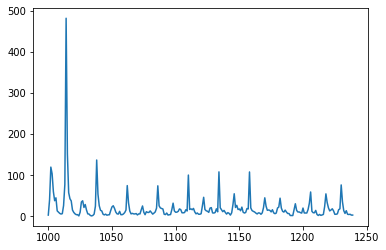

In [235]:
plt.plot(dup['price'][1000:1240]) #so, obvious pattern of some sort, but not daily...morn/eve peaks?
#honestly this looks extremely predictable, we just have to figure out when those spikes are
#may be that we can predict some hours well and some hours not well...[but obvi we care about price spikes most]

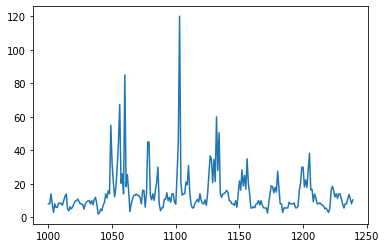

In [234]:
plt.plot(ddown['price'][1000:1240])


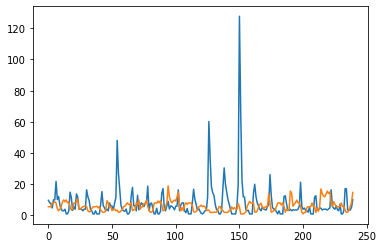

In [233]:
plt.plot(dup['price'][0:240])
plt.plot(ddown['price'][0:240]) #inversely varying? yes, duh

Why are there a million rows in DAH and only like 1/40 as many in RTH?

(array([4391., 4393., 4367., 4393., 4367., 4393., 4391., 4369., 4391.,
        4370.]),
 array([735234. , 735416.6, 735599.2, 735781.8, 735964.4, 736147. ,
        736329.6, 736512.2, 736694.8, 736877.4, 737060. ]),
 <a list of 10 Patch objects>)

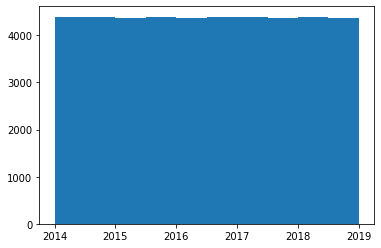

In [197]:
plt.hist(as_dict['DAHDown Regulation']['date'])

(array([ 69.,  67.,  75., 132., 104., 122., 201., 145., 149., 247.]),
 array([    0.,  8280., 16560., 24840., 33120., 41400., 49680., 57960.,
        66240., 74520., 82800.]),
 <a list of 10 Patch objects>)

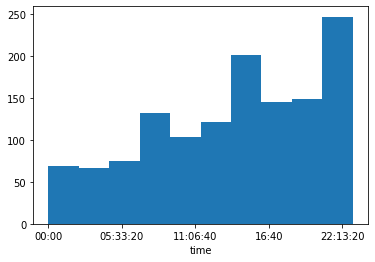

In [200]:
plt.hist(as_dict['RTHDown Regulation']['hr_beg']) #so weird!! just missing a bunch of days/hours???
#or maybe just only rebid sometimes in real time? this makes the most sense

# energy_prices

In [65]:
df_energy = pd.read_csv(path+'energy_price.csv')

In [66]:
df_energy.head()

,Price Node Name,Local Datetime (Hour Ending),Time Zone,Price Type Full Description,Is Derived (Y/N),Price $/MWh,Record Count,Price Type,Market,Volume MWh,Price Node ID
0,HB_BUSAVG,1/1/2014 00:00,CST,ERCOT-DAH SPP,N,32.590,1,SPP,DAH,NaN,1323535
1,HB_BUSAVG,1/1/2014 00:00,CST,ERCOT-RT15AVG SPP,Y,23.825,1,SPP,RT15AVG,NaN,1323535
2,HB_BUSAVG,1/1/2014 01:00,CST,ERCOT-DAH SPP,N,28.120,1,SPP,DAH,NaN,1323535
3,HB_BUSAVG,1/1/2014 01:00,CST,ERCOT-RT15AVG SPP,Y,24.675,1,SPP,RT15AVG,NaN,1323535
4,HB_BUSAVG,1/1/2014 02:00,CST,ERCOT-DAH SPP,N,25.030,1,SPP,DAH,NaN,1323535


In [67]:
df_energy['dt'] = pd.to_datetime(df_energy['Local Datetime (Hour Ending)'])

In [72]:
df_energy['dt_beg'] = df_energy['dt'].apply(lambda x: x - datetime.timedelta(hours=1))

In [74]:
df_energy['date'] = df_energy['dt_beg'].dt.date
df_energy['hr_beg'] = df_energy['dt_beg'].dt.time

In [76]:
df_energy = df_energy[['Price Node Name','Price Type','Market','date','hr_beg','Price $/MWh']].reset_index(drop=True)
df_energy.columns = ['node','price_type','market','date','hr_beg','price']

In [77]:
df_energy.head()

,node,price_type,market,date,hr_beg,price
0,HB_BUSAVG,SPP,DAH,2013-12-31,23:00:00,32.590
1,HB_BUSAVG,SPP,RT15AVG,2013-12-31,23:00:00,23.825
2,HB_BUSAVG,SPP,DAH,2014-01-01,00:00:00,28.120
3,HB_BUSAVG,SPP,RT15AVG,2014-01-01,00:00:00,24.675
4,HB_BUSAVG,SPP,DAH,2014-01-01,01:00:00,25.030


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


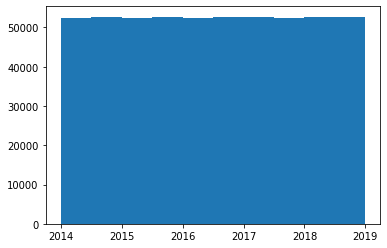

In [78]:
plt.hist(df_energy['date'])
plt.show()

In [79]:
for node in df_energy['node'].unique():
    df_energy[df_energy['node']==node].to_csv("energy_prices_"+node+".csv", index=False)

In [81]:
nodes = ['HB_BUSAVG', 'HB_HOUSTON', 'HB_HUBAVG', 'HB_NORTH', 'HB_SOUTH',
       'HB_WEST']
newnodes = ['busavg','houston','hubavg','N','S','W']

In [84]:
markets = ['DAH', 'RT15AVG']
newmarkets = ['DAH','RT15']

In [85]:
df_energy.head()

,node,price_type,market,date,hr_beg,price
0,HB_BUSAVG,SPP,DAH,2013-12-31,23:00:00,32.590
1,HB_BUSAVG,SPP,RT15AVG,2013-12-31,23:00:00,23.825
2,HB_BUSAVG,SPP,DAH,2014-01-01,00:00:00,28.120
3,HB_BUSAVG,SPP,RT15AVG,2014-01-01,00:00:00,24.675
4,HB_BUSAVG,SPP,DAH,2014-01-01,01:00:00,25.030


In [86]:
energy_output = df_energy.loc[:,'date':'hr_beg']

for i, market in enumerate(markets):
    for j, node in enumerate(nodes):
        subset = df_energy.loc[(df_energy['market']==market) & (df_energy['node']==node),['date','hr_beg','price']].rename(columns={'price':'price'+"_"+newmarkets[i]+"_"+newnodes[j],
                                                                                                                    })
        energy_output = energy_output.merge(subset, on=['date','hr_beg'], how="outer")

In [122]:
energy_output.to_csv("df_energy_price.csv", index=False)

In [87]:
energy_output

,date,hr_beg,price_DAH_busavg,price_DAH_houston,price_DAH_hubavg,price_DAH_N,price_DAH_S,price_DAH_W,price_RT15_busavg,price_RT15_houston,price_RT15_hubavg,price_RT15_N,price_RT15_S,price_RT15_W
0,2013-12-31,23:00:00,32.59,32.56,32.55,32.65,32.50,32.49,23.8250,23.8450,23.5625,24.1875,23.575,22.6350
1,2013-12-31,23:00:00,32.59,32.56,32.55,32.65,32.50,32.49,23.8250,23.8450,23.5625,24.1875,23.575,22.6350
2,2013-12-31,23:00:00,32.59,32.56,32.55,32.65,32.50,32.49,23.8250,23.8450,23.5625,24.1875,23.575,22.6350
3,2013-12-31,23:00:00,32.59,32.56,32.55,32.65,32.50,32.49,23.8250,23.8450,23.5625,24.1875,23.575,22.6350
4,2013-12-31,23:00:00,32.59,32.56,32.55,32.65,32.50,32.49,23.8250,23.8450,23.5625,24.1875,23.575,22.6350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017283,2018-12-31,23:00:00,20.51,20.00,20.53,20.47,20.67,20.97,15.4525,15.3825,15.4525,15.4450,15.520,15.4575
1017284,2018-12-31,23:00:00,20.51,20.00,20.53,20.47,20.67,20.97,15.4525,15.3825,15.4525,15.4450,15.520,15.4575
1017285,2018-12-31,23:00:00,20.51,20.00,20.53,20.47,20.67,20.97,15.4525,15.3825,15.4525,15.4450,15.520,15.4575
1017286,2018-12-31,23:00:00,20.51,20.00,20.53,20.47,20.67,20.97,15.4525,15.3825,15.4525,15.4450,15.520,15.4575


# Weather

New data from near Houston, Dallas, and San Antonio

In [142]:
#loading all data and concatenating
path = r'/Users/margaretmccall/Documents/2020 Spring/CE 295/0 - Final Project/data_dump_will/weather'
all_files = glob.glob(path + "/*.csv")

dfs = []
bad_files = []

for file in all_files:
    try:
        x = pd.read_csv(file)
        name = file.replace(path,"")
        name = name.replace('.csv',"")
        x['Name'] = name
        dfs.append(x)
    except pd.errors.EmptyDataError:
        bad_files.append(file)
        
df = pd.concat(dfs, ignore_index=True)

In [143]:
df['Name'].unique()

array(['/32.82_-97.05_2014', '/29.48_-98.3_2017', '/29.48_-98.3_2016',
       '/32.82_-97.05_2015', '/32.82_-97.05_2017', '/29.48_-98.3_2014',
       '/29.48_-98.3_2015', '/32.82_-97.05_2016', '/30.96_-103.35_2018',
       '/29.63_-96.08_2018', '/29.63_-96.08_2017', '/29.63_-96.08_2016',
       '/29.63_-96.08_2014', '/29.63_-96.08_2015', '/30.96_-103.35_2015',
       '/29.48_-98.3_2018', '/30.96_-103.35_2014', '/30.96_-103.35_2016',
       '/32.82_-97.05_2018', '/30.96_-103.35_2017'], dtype=object)

In [144]:
df['coord1'] = df['Name'].apply(lambda s: s[1:s.find('_-')])
df['coord2'] = df['Name'].apply(lambda s: s[8:s.find('_2')])

In [145]:
df['Name'] = df['Name'].apply(lambda s: s[:-5])

In [237]:
df.head(50)

,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle,Name,coord1,coord2
0,2014,1,1,0,30,0,0,0,0.9,2.0,173.34,AustinSA,29.48,98.3
1,2014,1,1,0,30,0,0,0,0.8,4.0,173.33,Houston,29.63,96.08
2,2014,1,1,0,30,0,0,0,3.0,4.0,170.04,WestTX,30.96,103.35
3,2014,1,1,0,30,0,0,0,2.8,0.0,170.18,Dallas,32.82,97.05
4,2014,1,1,1,30,0,0,0,0.8,1.0,166.40,AustinSA,29.48,98.3
5,2014,1,1,1,30,0,0,0,0.7,4.0,164.59,Houston,29.63,96.08
6,2014,1,1,1,30,0,0,0,3.1,4.0,169.13,WestTX,30.96,103.35
7,2014,1,1,1,30,0,0,0,2.8,0.0,163.83,Dallas,32.82,97.05
8,2014,1,1,2,30,0,0,0,0.8,1.0,153.84,AustinSA,29.48,98.3
9,2014,1,1,2,30,0,0,0,0.7,4.0,151.92,Houston,29.63,96.08


In [148]:
realnames = {'/29.48_-98.3': 'AustinSA',
             '/32.82_-97.05': 'Dallas',
             '/30.96_-103.35': 'WestTX',
            '/29.63_-96.08': 'Houston'}

In [149]:
#this is stupid
for key in realnames.keys():
    df.loc[df['Name']==key,'Name'] = realnames[key]

In [151]:
df.sort_values(by=['Year','Month','Day','Hour','Minute','coord1','coord2'], inplace=True)

In [152]:
df.reset_index(inplace=True, drop=True)

In [154]:
df.head()

,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle,Name,coord1,coord2
0,2014,1,1,0,30,0,0,0,0.9,2.0,173.34,AustinSA,29.48,98.3
1,2014,1,1,0,30,0,0,0,0.8,4.0,173.33,Houston,29.63,96.08
2,2014,1,1,0,30,0,0,0,3.0,4.0,170.04,WestTX,30.96,103.35
3,2014,1,1,0,30,0,0,0,2.8,0.0,170.18,Dallas,32.82,97.05
4,2014,1,1,1,30,0,0,0,0.8,1.0,166.40,AustinSA,29.48,98.3


In [155]:
df.to_csv("weather_data.csv")

# Generator data

In [101]:
path = '/Users/margaretmccall/Documents/2020 Spring/CE 295/0 - Final Project/data_dump_will/'
df_gen = pd.read_csv(path+'ERCOT_hourly_by_BA_v5.csv')

In [102]:
df_gen.head()

,local_time_cems,utc,datetime,Coal,GT,NGCC,Nuclear.x,ST,Other,Load.MW,...,ramp_abs,max_ramp,max_ramp_abs,Biomass,Hydro,Imports,Nuclear.y,Solar,Wind,ng_price
0,2010-01-01T08:00:00Z,2010-01-01T08:00:00Z,1/1/2010 02:00,15608.14,746.96,8705.99,5171.0,383.60,NaN,32308.56,...,131.67,2437.34,2437.34,NaN,12.31,NaN,5171.69,NaN,1285.23,5.741
1,2010-01-01T09:00:00Z,2010-01-01T09:00:00Z,1/1/2010 03:00,15532.08,746.95,8617.26,5171.0,375.78,NaN,32520.76,...,401.30,2437.34,2437.34,NaN,12.32,NaN,5170.11,NaN,1898.73,5.741
2,2010-01-01T10:00:00Z,2010-01-01T10:00:00Z,1/1/2010 04:00,15694.58,745.00,8818.14,5171.0,472.17,NaN,33190.19,...,41.95,2437.34,2437.34,NaN,12.32,NaN,5170.15,NaN,2526.21,5.741
3,2010-01-01T11:00:00Z,2010-01-01T11:00:00Z,1/1/2010 05:00,15502.46,744.03,9276.63,5171.0,581.74,NaN,34377.56,...,752.33,2437.34,2437.34,NaN,12.58,NaN,5170.77,NaN,2961.25,5.741
4,2010-01-01T12:00:00Z,2010-01-01T12:00:00Z,1/1/2010 06:00,15548.02,762.51,10251.94,5171.0,573.46,NaN,35592.75,...,1395.30,2437.34,2437.34,NaN,92.11,NaN,5170.57,NaN,2781.14,5.741


The datetimes are weird--local time and UTC seem to be the same? datetime column seems most likely to be central time

In [103]:
df_gen['dt1'] = pd.to_datetime(df_gen['local_time_cems'])
df_gen['dt2'] = pd.to_datetime(df_gen['utc'])
df_gen['dt3'] = pd.to_datetime(df_gen['datetime'])


In [104]:
df_gen.columns

Index(['local_time_cems', 'utc', 'datetime', 'Coal', 'GT', 'NGCC', 'Nuclear.x',
       'ST', 'Other', 'Load.MW', 'Total', 'UPV', 'solar_ISO', 'wind',
       'load_naked', 'load_net', 'ramp', 'ramp_abs', 'max_ramp',
       'max_ramp_abs', 'Biomass', 'Hydro', 'Imports', 'Nuclear.y', 'Solar',
       'Wind', 'ng_price', 'dt1', 'dt2', 'dt3'],
      dtype='object')

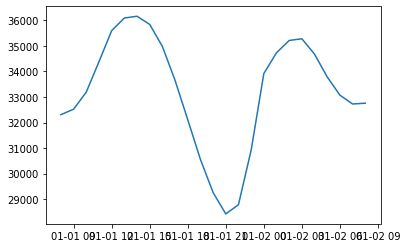

In [105]:
plt.plot(df_gen.loc[:24,'dt2'], df_gen.loc[:24,'load_naked'], label='starts at 8am')

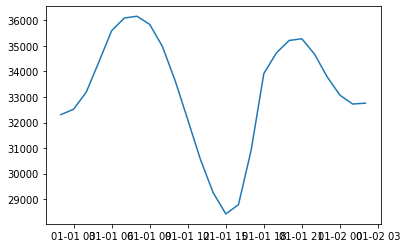

In [106]:
plt.plot(df_gen.loc[:24,'dt3'], df_gen.loc[:24,'load_naked'], label='starts at 2am') #this is more reasonable

In [111]:
df_gen['date'] = df_gen['dt3'].dt.date
df_gen['hr_beg'] = df_gen['dt3'].dt.time

In [112]:
df_gen.head()

,local_time_cems,utc,datetime,Coal,GT,NGCC,Nuclear.x,ST,Other,Load.MW,...,Nuclear.y,Solar,Wind,ng_price,dt1,dt2,dt3,date,hour,hr_beg
0,2010-01-01T08:00:00Z,2010-01-01T08:00:00Z,1/1/2010 02:00,15608.14,746.96,8705.99,5171.0,383.60,NaN,32308.56,...,5171.69,NaN,1285.23,5.741,2010-01-01 08:00:00+00:00,2010-01-01 08:00:00+00:00,2010-01-01 02:00:00,2010-01-01,02:00:00,02:00:00
1,2010-01-01T09:00:00Z,2010-01-01T09:00:00Z,1/1/2010 03:00,15532.08,746.95,8617.26,5171.0,375.78,NaN,32520.76,...,5170.11,NaN,1898.73,5.741,2010-01-01 09:00:00+00:00,2010-01-01 09:00:00+00:00,2010-01-01 03:00:00,2010-01-01,03:00:00,03:00:00
2,2010-01-01T10:00:00Z,2010-01-01T10:00:00Z,1/1/2010 04:00,15694.58,745.00,8818.14,5171.0,472.17,NaN,33190.19,...,5170.15,NaN,2526.21,5.741,2010-01-01 10:00:00+00:00,2010-01-01 10:00:00+00:00,2010-01-01 04:00:00,2010-01-01,04:00:00,04:00:00
3,2010-01-01T11:00:00Z,2010-01-01T11:00:00Z,1/1/2010 05:00,15502.46,744.03,9276.63,5171.0,581.74,NaN,34377.56,...,5170.77,NaN,2961.25,5.741,2010-01-01 11:00:00+00:00,2010-01-01 11:00:00+00:00,2010-01-01 05:00:00,2010-01-01,05:00:00,05:00:00
4,2010-01-01T12:00:00Z,2010-01-01T12:00:00Z,1/1/2010 06:00,15548.02,762.51,10251.94,5171.0,573.46,NaN,35592.75,...,5170.57,NaN,2781.14,5.741,2010-01-01 12:00:00+00:00,2010-01-01 12:00:00+00:00,2010-01-01 06:00:00,2010-01-01,06:00:00,06:00:00


In [113]:
df_gen.columns

Index(['local_time_cems', 'utc', 'datetime', 'Coal', 'GT', 'NGCC', 'Nuclear.x',
       'ST', 'Other', 'Load.MW', 'Total', 'UPV', 'solar_ISO', 'wind',
       'load_naked', 'load_net', 'ramp', 'ramp_abs', 'max_ramp',
       'max_ramp_abs', 'Biomass', 'Hydro', 'Imports', 'Nuclear.y', 'Solar',
       'Wind', 'ng_price', 'dt1', 'dt2', 'dt3', 'date', 'hour', 'hr_beg'],
      dtype='object')

In [114]:
df_gen.drop(columns=['dt1','dt2','dt3','hour'], inplace=True)

In [115]:
df_gen.drop(columns=['local_time_cems','utc','datetime'], inplace=True)

In [116]:
df_gen['year'] = df_gen['date'].apply(lambda x: x.year)

In [117]:
df_gen = df_gen[df_gen['year'] > 2013]

In [120]:
df_gen.drop(columns=['year'], inplace=True)

In [124]:
df_gen.to_csv('df_generation.csv', index=False)